In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from google.cloud import storage
from io import BytesIO

In [118]:
random_stat = 123

storage_client = storage.Client(project = 'ih-final-project-277919')

bucket = storage_client.get_bucket("data_images_ih")

SIZE = 416 #p1
#SIZE = 608 #open images


In [119]:
#!git clone https://github.com/pjreddie/darknet.git

# Build gpu version darknet
#!cd darknet && sed '1 s/^.*$/GPU=1/; 2 s/^.*$/CUDNN=1/' -i Makefile

# -j <The # of cpu cores to use>. Chang 999 to fit your environment. Actually i used '-j 50'.
#!cd darknet && make -j 999 -s
#!cp darknet/darknet darknet_gpu

In [120]:
#bucket = storage_client.get_bucket("final_project_ih_data_dl")
#list(bucket.list_blobs())

In [121]:
DATA_DIR = "/home/jupyter/data/"

train_dir = os.path.join(DATA_DIR, "train_images")
test_dir = os.path.join(DATA_DIR, "test_images")

img_dir = os.path.join(os.getcwd(), "images")  # .jpg
label_dir = os.path.join(os.getcwd(), "labels")  # .txt
metadata_dir = os.path.join(os.getcwd(), "metadata") # .txt

# YOLOv3 config file directory
cfg_dir = os.path.join(os.getcwd(), "cfg")
# YOLOv3 training checkpoints will be saved here
backup_dir = os.path.join(os.getcwd(), "backup")

for directory in [img_dir, label_dir, metadata_dir, cfg_dir, backup_dir,train_dir,test_dir]:
    if os.path.isdir(directory):
        continue
    os.mkdir(directory)

In [122]:
colnames=['LabelName','Label']
df_class = pd.read_csv('data/class-descriptions-boxable.csv',names=colnames, header=None)

In [123]:
df_class.head()

,LabelName,Label
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


In [124]:
annots = pd.read_csv('data/df_all_data.csv')
annots.head()

,ImageID,Subset,OriginalURL,OriginalLandingURL,License,AuthorProfileURL,Author,Title,OriginalSize,OriginalMD5,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,25e3acb1a25707dd,train,https://c6.staticflickr.com/8/7659/17891339551...,https://www.flickr.com/photos/archiefalkmaar/1...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/archiefalkmaar/,Regionaal Archief Alkmaar,Vrijwilligersuitje 2015,2677536,FvIDdDhff45GCENbR2CXuQ==,...,0,0,0.715000,0.766875,0.999375,0.390625,0.438149,0.999056,0.885741,0.915958
1,9aaa4a4bce049a85,train,https://farm6.staticflickr.com/8164/7388947910...,https://www.flickr.com/photos/45131642@N00/738...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/45131642@N00/,Phil Parker,Decks and Boats in,28624,8Jqvyk2WuArDznavCtpBnA==,...,1,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2,6db5e012cf2936fa,train,https://c3.staticflickr.com/3/2874/9062318686_...,https://www.flickr.com/photos/atgeist/9062318686,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/atgeist/,TownePost Network,Cocktail Cove cuties get the party started,5036881,6Rn5G58CFybS6b1wUeTApg==,...,0,0,0.975000,0.999375,0.780625,0.037500,0.381341,0.456522,0.999094,0.999094
3,6db5e012cf2936fa,train,https://c3.staticflickr.com/3/2874/9062318686_...,https://www.flickr.com/photos/atgeist/9062318686,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/atgeist/,TownePost Network,Cocktail Cove cuties get the party started,5036881,6Rn5G58CFybS6b1wUeTApg==,...,0,0,0.690000,0.231250,0.185000,0.700000,0.241848,0.395833,0.494565,0.259058
4,6db5e012cf2936fa,train,https://c3.staticflickr.com/3/2874/9062318686_...,https://www.flickr.com/photos/atgeist/9062318686,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/atgeist/,TownePost Network,Cocktail Cove cuties get the party started,5036881,6Rn5G58CFybS6b1wUeTApg==,...,0,0,0.766875,0.265625,0.337500,0.778125,0.210145,0.455616,0.526268,0.368659


In [125]:
annots.shape

(79113, 32)

In [126]:
annots = annots.merge(df_class, left_on = 'LabelName', right_on ='LabelName')

In [127]:
annots.drop_duplicates(inplace=True)

In [128]:
annots.shape

(79113, 33)

In [129]:
annots.columns

Index(['ImageID', 'Subset', 'OriginalURL', 'OriginalLandingURL', 'License',
       'AuthorProfileURL', 'Author', 'Title', 'OriginalSize', 'OriginalMD5',
       'Thumbnail300KURL', 'Rotation', 'Source', 'LabelName', 'Confidence',
       'XMin', 'XMax', 'YMin', 'YMax', 'IsOccluded', 'IsTruncated',
       'IsGroupOf', 'IsDepiction', 'IsInside', 'XClick1X', 'XClick2X',
       'XClick3X', 'XClick4X', 'XClick1Y', 'XClick2Y', 'XClick3Y', 'XClick4Y',
       'Label'],
      dtype='object')

In [130]:
annots_masks = annots[['ImageID','XMin', 'XMax', 'YMin', 'YMax','Label','Confidence']]
annots_masks.head()

,ImageID,XMin,XMax,YMin,YMax,Label,Confidence
0,25e3acb1a25707dd,0.390625,0.999375,0.438149,0.999056,Boat,1
1,9aaa4a4bce049a85,0.015919,0.946454,0.096610,0.901695,Boat,1
2,6db5e012cf2936fa,0.037500,0.999375,0.381341,0.999094,Boat,1
3,6db5e012cf2936fa,0.185000,0.700000,0.241848,0.494565,Boat,1
4,6db5e012cf2936fa,0.265625,0.778125,0.210145,0.526268,Boat,1


In [131]:
def save_label(label_dir, image_id, row=None):
    
    #if os.path.isfile(os.path.join(label_dir, "{}.txt".format(image_id)))==True:
    if False:
            return
    else:

        label_fp = os.path.join(label_dir, "{}.txt".format(image_id))

        f = open(label_fp, "a")
        if row is None:
            f.close()
            return

        XMin = row[1]
        XMax = row[2]
        YMin = row[3]
        YMax = row[4]
        label = row[5]
        label = 0

        rw = (XMax-XMin)
        rh = (YMax - YMin)
        rcx = XMin + rw/2
        rcy = YMin + rh/2

        #we use object as 0 as we only have 1 class.

        line = "{} {} {} {} {}\n".format(label, rcx, rcy, rw, rh)

        f.write(line)
        f.close()

In [132]:
def save_image(img_dir, image_id, image_blob, dim):
    
    
    try:
        if os.path.isfile(os.path.join(img_dir, "{}.jpg".format(image_id)))==True:
            return
        else:
            img_fp = os.path.join(img_dir, "{}.jpg".format(image_id))
            image = np.asarray(bytearray(image_blob.download_as_string()), dtype="uint8")
            image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)
            resized_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

            if len(resized_image.shape) == 2:
                resized_image = cv2.cvtColor(resized_image,cv2.COLOR_GRAY2RGB)

            cv2.imwrite(img_fp, resized_image)
    except:
        #print(f'image: {image_id} missing, {image_blob} ')

        return image_id

In [133]:
for row in tqdm(annots_masks.values):
        image_id = row[0]
        save_label(label_dir, image_id, row)

100%|██████████| 79113/79113 [00:03<00:00, 21464.89it/s]


In [134]:
image_annots = annots[['ImageID','OriginalURL']]
image_annots.loc[:,'OriginalURL'] = image_annots.loc[:,'OriginalURL'].apply(lambda x: x.replace('https://',''))

image_annots.drop_duplicates(inplace = True)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [135]:
image_annots.head()

,ImageID,OriginalURL
0,25e3acb1a25707dd,c6.staticflickr.com/8/7659/17891339551_6ae11be...
1,9aaa4a4bce049a85,farm6.staticflickr.com/8164/7388947910_8ea3aa9...
2,6db5e012cf2936fa,c3.staticflickr.com/3/2874/9062318686_f4917058...
6,ad3d362f5abb39e5,farm6.staticflickr.com/5720/21163261942_4ab31f...
8,9172175c072967ae,c7.staticflickr.com/1/64/214333364_5dd9c7ece5_...


In [136]:
images = 2000

In [95]:
WIDTH = SIZE
HEIGHT = SIZE
dim = (WIDTH, HEIGHT)

not_images =[]

for row in tqdm(image_annots.values[:images]):
        image_id = row[0]
        image_blob = bucket.blob(row[1])
        not_img = save_image(img_dir, image_id,image_blob,dim)
        
        not_images.append(not_img)

100%|██████████| 2000/2000 [00:10<00:00, 184.67it/s]


In [137]:
not_images_2 = [x for x in not_images if x is not None]

In [138]:
len(not_images_2)

134

In [139]:
#print(not_images_2)

In [160]:
image_annots = image_annots[~image_annots['ImageID'].isin(not_images_2)][:(images-len(not_images_2)-10)]

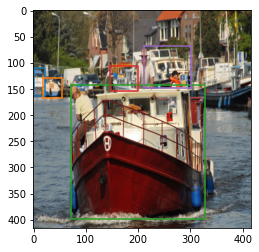

In [161]:
ex_image_id = image_annots.ImageID.values[80]
ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_image_id))
ex_label_path = os.path.join(label_dir, "{}.txt".format(ex_image_id))

plt.imshow(cv2.cvtColor(cv2.imread(ex_img_path),cv2.COLOR_BGR2RGB))
    
with open(ex_label_path, "r") as f:
    for line in f:
        x = line.strip().split()
        class_name  = x[0]
        rcx, rcy, rw, rh = [float(i) for i in x[1:]]
        x = (rcx-rw/2)*dim[0]
        y = (rcy-rh/2)*dim[1]
        w = rw*dim[0]
        h = rh*dim[1]
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

In [162]:
def write_train_list(metadata_dir, img_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)

    with open(list_fp, "w") as f:
        for image_id in series:
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(image_id)))
            f.write(line)

In [163]:
image_annots.shape

(1856, 2)

In [164]:
tr_series, val_series = train_test_split(image_annots['ImageID'], test_size=0.1, random_state=random_stat)
print("The # of train set: {}, The # of validation set: {}".format(tr_series.shape[0], val_series.shape[0]))

# train image path list
write_train_list(metadata_dir, img_dir, "tr_list.txt", tr_series)
# validation image path list
write_train_list(metadata_dir, img_dir, "val_list.txt", val_series)

The # of train set: 1670, The # of validation set: 186


In [165]:
#Esto no funciona pero tampoco se para que sirve si ya tenemos la metadata con trin y validation lists (paths imagenes)

#La idea es crear test images. Se puede mirar luego

In [166]:
def save_image_test(test_dir, img_dir, image_id):
    
    ex_img_path = os.path.join(img_dir, "{}.jpg".format(image_id))
    print(ex_img_path)
    
    img_path = os.path.join(img_dir,"{}.jpg".format(image_id))
    img_test_path = os.path.join(test_dir,"{}.jpg".format(image_id))
    
    image = cv2.imread(img_path)
    print(image)
    print(img_path)
    print(img_test_path)
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    
    
    cv2.imwrite(img_test_path,image)
    

In [167]:
def save_yolov3_test_data(test_dir, img_dir, metadata_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        series = series[:10]
        for image_id in series:
            save_image_test(test_dir, img_dir, image_id)
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(image_id)))
            f.write(line)

In [168]:
data_extention_file_path = os.path.join(cfg_dir, 'p1.data')
with open(data_extention_file_path, 'w') as f:
    contents = """classes= 1
train  = {}
valid  = {}
names  = {}
backup = {}
    """.format(os.path.join(metadata_dir, "tr_list.txt"),
               os.path.join(metadata_dir, "val_list.txt"),
               os.path.join(cfg_dir, 'p1.names'),
               backup_dir)
    f.write(contents)

In [169]:
!cat cfg/p1.data

classes= 1
train  = /home/jupyter/metadata/tr_list.txt
valid  = /home/jupyter/metadata/val_list.txt
names  = /home/jupyter/cfg/p1.names
backup = /home/jupyter/backup
    

In [170]:
!echo "boat" > cfg/p1.names

In [171]:
!cd darknet

In [172]:
#!wget https://pjreddie.com/media/files/yolov3.weights

In [173]:
#!wget -q https://pjreddie.com/media/files/darknet53.conv.74

In [174]:
#!wget https://pjreddie.com/media/files/darknet53.conv.74

In [175]:
# ESTE FUNCIONA !./darknet_gpu detector train cfg/p1.data cfg/yolov3-p1.cfg darknet53.conv.74

In [176]:
print(dim)

(416, 416)


In [180]:
#ESTE FUNCIONA y genera train_log 
print(dim)
#!./darknet_gpu detector train cfg/p1.data cfg/yolov3-open1.cfg darknet53.conv.74 -i 0 | tee train_log_open.txt

!./darknet_gpu detector train cfg/p1.data cfg/yolov3-p1.cfg darknet53.conv.74 -i 0 | tee train_log_p1.txt

(416, 416)
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32  0.299 BFLOPs
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32  0.177 BFLOPs
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64  1.595 BFLOPs
    4 res    1                 208 x 208 x  64   ->   208 x 208 x  64
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128  1.595 BFLOPs
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64  0.177 BFLOPs
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128  1.595 BFLOPs
    8 res    5                 104 x 104 x 128   ->   104 x 104 x 128
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64  0.177 BFLOPs
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128  1.595 BFLOPs
   11 res    8            

Text(0, 0.5, 'Loss')

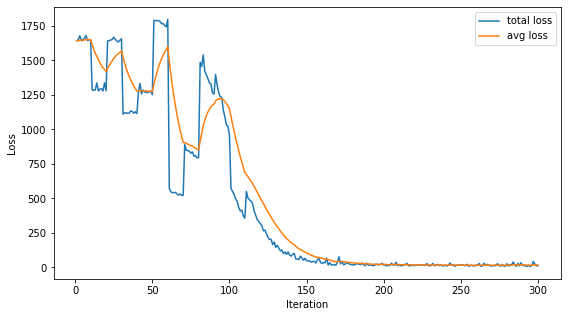

In [4]:
iters = []
losses = []
total_losses = []
with open("train_log_p1.txt", 'r') as f:
    for i,line in enumerate(f):
        if "images" in line:
            iters.append(int(line.strip().split()[0].split(":")[0]))
            losses.append(float(line.strip().split()[2]))        
            total_losses.append(float(line.strip().split()[1].split(',')[0]))

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.lineplot(iters, total_losses, label="total loss")
sns.lineplot(iters, losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")